In [25]:
%pylab inline
import astropy.io.fits as fitsio
import glob
import scipy.stats as stats
matplotlib.rcParams.update({'font.size': 16})

Populating the interactive namespace from numpy and matplotlib


In [103]:
images = ["sphe/{0:04d}-wsclean-image.fits".format(d) for d in range(1800, 1900)]
residuals_ws = ["sphe/{0:04d}-wsclean-residual.fits".format(d) for d in range(1800, 1900)]
residuals_vac = ["neural_ouput_pixel_scaling_exp2/{0:04d}-residuals.fits".format(d) for d in range(1800,1900)]
skies = ["sphe/{0:04d}-skymodel.fits".format(d) for d in range(1800, 1900)]
wsclean = ["sphe/{0:04d}-wsclean-model.fits".format(d) for d in range(1800, 1900)]
vacuum  = ["neural_ouput_pixel_scaling_exp2/{0:4d}-outputs.fits".format(d) for d in range(1800, 1900)]
N = len(skies)

tests = {
    "wsclean" : {
    "normality" : [],
    "rms"       : [],
    "L1"        : [],
    "mad"       : [],
    }, 
    "vacuum"   : {
    "normality" : [],
    "rms"       : [],
    "L1"        : [],
    "mad"       : [],
    },
}

for i in range(N):
    im = images[i]
    res_ws_ = residuals_ws[i]
    res_vac_ = residuals_vac[i]
    skyim = skies[i]
    model_ws = wsclean[i]
    model_vac = vacuum[i]
    
    with fitsio.open(im) as hdu:
        data = hdu[0].data
    with fitsio.open(res_ws_) as hdu:
        res_ws = hdu[0].data
    with fitsio.open(res_vac_) as hdu:
        res_vac = hdu[0].data
    with fitsio.open(skyim) as hdu:
        sky = hdu[0].data
    with fitsio.open(model_ws) as hdu:
        ws = hdu[0].data
        NPix = hdu[0].header["NAXIS1"]
    with fitsio.open(model_vac) as hdu:
        vac = hdu[0].data
        
    # Stats for wsclean    
    k2,_ = stats.normaltest(res_ws.flatten())
    tests["wsclean"]["normality"].append(k2)
    
    tests["wsclean"]["rms"].append(res_ws.std())
    
    L1 = sum ( abs(sky - ws) )
    tests["wsclean"]["L1"].append(L1)
    
    mad = np.mean( abs(res_ws - np.mean(res_ws)) )
    tests["wsclean"]["mad"].append(res_ws.std())
    
    # Stats for vacuum
    k2,_ = stats.normaltest(res_vac.flatten())
    tests["vacuum"]["normality"].append(k2)
    
    tests["vacuum"]["rms"].append(res_vac.std())
    
    L1 = sum ( abs(sky - vac) )
    tests["vacuum"]["L1"].append(L1)
    
    mad = np.mean( abs(res_vac - np.mean(res_vac)) )
    tests["vacuum"]["mad"].append(mad)
    
    

100


## Quality Assessment

In [126]:
def plot_stat(stat="rms"):
    """
    Plot statistic
    """
    pylab.clf()
    pylab.figure(figsize=(14,12))
    grid = pylab.GridSpec(2, 3, wspace=0.3, hspace=0.2)

    ax1 = pylab.subplot(grid[0:2, 0:2])
    ax2 = pylab.subplot(grid[0, 2])
    ax3 = pylab.subplot(grid[1, 2])

    ax1.scatter(tests["wsclean"][stat], tests["vacuum"][stat])
    ax1.plot(tests["wsclean"][stat], tests["wsclean"][stat], "r-")
    ax1.set_ylabel("wsclean {0:s}".format(stat))
    ax1.set_xlabel("Vacuum Cleaner {0:s}".format(stat))
    ax1.grid()
    min_ = min(tests["wsclean"][stat] + tests["vacuum"][stat])*1.1
    max_ = max(tests["wsclean"][stat] + tests["vacuum"][stat])*1.1
    ax1.set_xlim(min_, max_)
    ax1.set_ylim(min_, max_)
    


    ax2.hist(tests["wsclean"][stat], bins=50, histtype="step")
    ax2.set_ylabel("Count")
    ax2.set_title("wsclean")
    ax2.grid()

    ax3.hist(tests["vacuum"][stat], bins=50, histtype="step")
    ax3.set_xlabel(stat)
    ax3.set_ylabel("Count")
    ax3.set_title("vacuum")
    ax3.grid()

<Figure size 432x288 with 0 Axes>

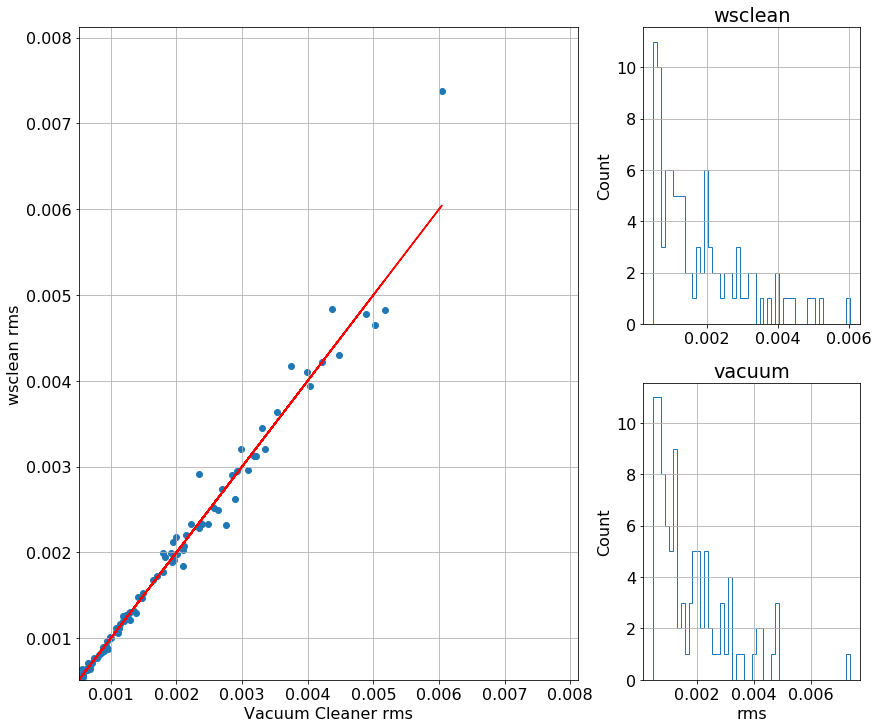

In [127]:
plot_stat("rms")

Left: The median absolute deviation (MAD) of the residual from wsclean versus that of the residual from vacuum-cleaner. Top right: Histogram of the MAD of the residuals from wsclean. Bottom right: Histogram of the MAD of the residuals from vacuum-cleaner. 

<Figure size 432x288 with 0 Axes>

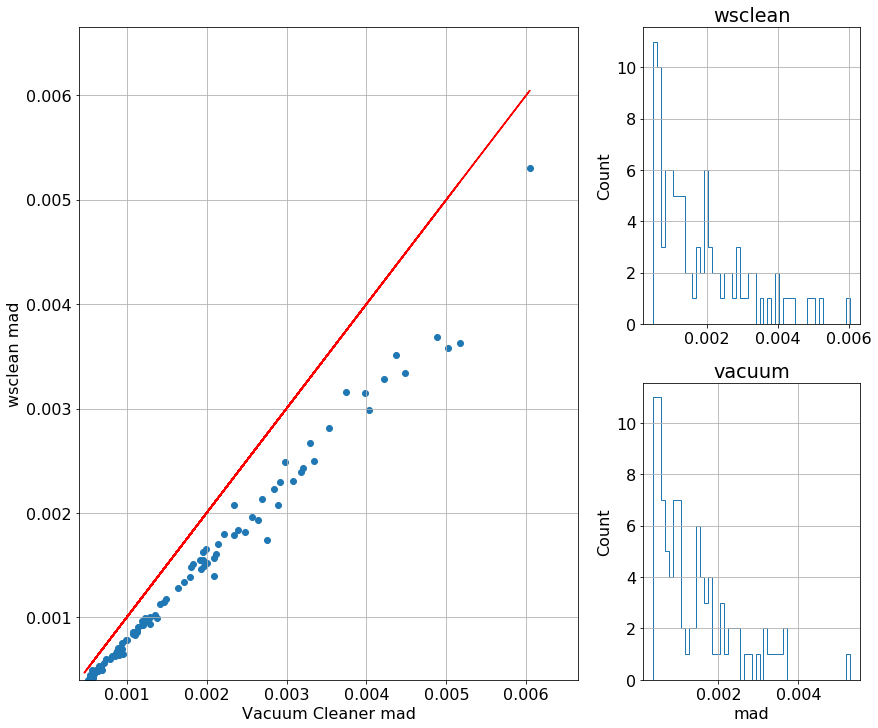

In [128]:
plot_stat("mad")

<Figure size 432x288 with 0 Axes>

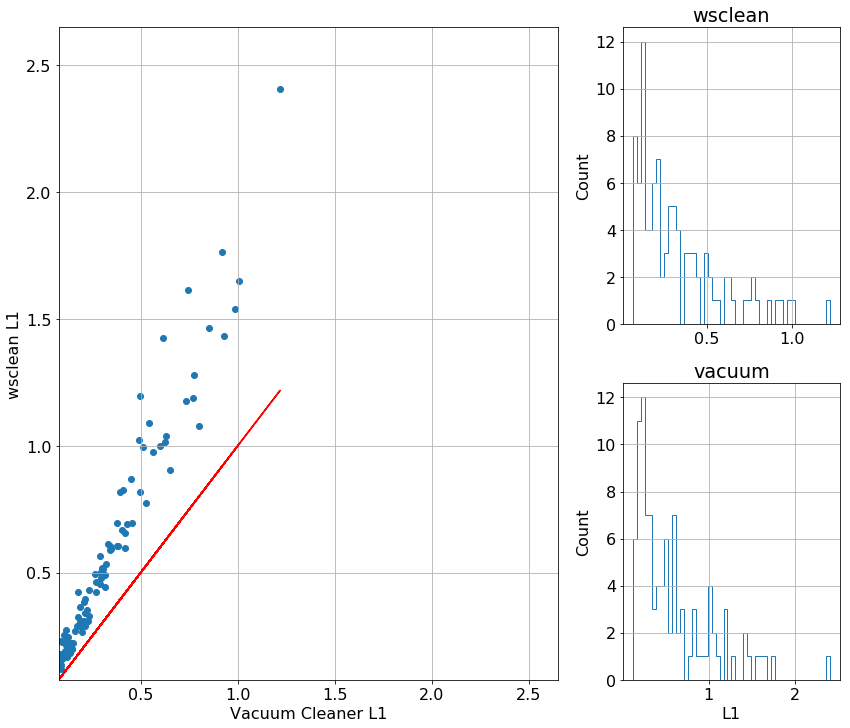

In [129]:
plot_stat("L1")